## Import Libraries

In [58]:
%matplotlib inline

In [2]:
import pandas as pd
import numpy as np
import json
from mplsoccer import Pitch
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")

## Visualize pass actions

- We will maybe not yet be able to give half-time advice but we will learn ways to visualise the data in the way that helps coaching staff understand the game better.


## Collecting Data

In [3]:
# Open the file and load its contents into a dictionary
with open('../data/StatsBomb/Data/ManCity_Arsenal_events.json', 'r') as f:
    data = json.load(f)

In [4]:
# Convert the list of JSON values to a DataFrame
df = pd.json_normalize(data)

In [5]:
teams_comp = list(df['team.name'].value_counts().keys())

## Preparing the data
For passing networks we use only accurate/successful passes made by a team until the first substitution.
This is mainly just to get going and there are several possible variations of this.
We need information about pass start and end location as well as player who made and received the pass. 
To make the vizualisation clearer, we annotate the players using their surname.
(This works for English women side, since players' surnames  are single-barrelled. But
can cause problems.For example, Leo Messi's name in Statsbomb is Lionel Andrés Messi Cuccittini. So the
name Cuccittini will come up if you run this code on his matches!).

In [21]:
def prepare_data_pass(df,team_name,sub=True):
    #check for index of first sub
    if sub:
        sub = df.loc[df["type.name"] == "Substitution"].loc[df["team.name"] == team_name].iloc[0]["index"]

    #make df with successfull passes by Manchester City until the first substitution
    if sub:
        mask_mancity = (df['type.name'] == 'Pass')\
        & (df['team.name']==team_name) \
        & (df.index < sub) \
        &(df['substitution.replacement.name'].isnull())\
        &(~df['pass.recipient.name'].isnull())
    else:
        mask_mancity = (df['type.name'] == 'Pass')\
        & (df['team.name']==team_name) \
        &(df['substitution.replacement.name'].isnull())\
        &(~df['pass.recipient.name'].isnull()) 

    #taking necessary columns
    df_pass_details = df.loc[mask_mancity, ['location','pass.end_location','player.name','pass.recipient.name']]

    df_pass_details['x'] = [axes[0] for axes in df_pass_details['location'].values]
    df_pass_details['y'] = [axes[1] for axes in df_pass_details['location'].values]

    df_pass_details['end_x'] = [axes[0] for axes in df_pass_details['pass.end_location'].values]
    df_pass_details['end_y'] = [axes[1] for axes in df_pass_details['pass.end_location'].values]

    df_pass = df_pass_details[['x', 'y', 'end_x', 'end_y','player.name','pass.recipient.name']]

    #adjusting that only the surname of a player is presented.
    df_pass["player.name"] = df_pass["player.name"].apply(lambda x: str(x).split()[-1])
    df_pass["pass.recipient.name"] = df_pass["pass.recipient.name"].apply(lambda x: str(x).split()[-1])
    return df_pass

## Calculating vertices size and location
To calculate vertices size and location, first we create an empty dataframe.
For each player we calculate average location of passes made and receptions.
Then, we calculate number of passes made by each player.
As the last step, we calculate set he marker size to be proportional to number of passes.

In [7]:
def calculate_vertices(df_pass):
    scatter_df = pd.DataFrame()
    for i, name in enumerate(df_pass["player.name"].unique()):
        passx = df_pass.loc[df_pass["player.name"] == name]["x"].to_numpy()
        recx = df_pass.loc[df_pass["pass.recipient.name"] == name]["end_x"].to_numpy()
        passy = df_pass.loc[df_pass["player.name"] == name]["y"].to_numpy()
        recy = df_pass.loc[df_pass["pass.recipient.name"] == name]["end_y"].to_numpy()
        scatter_df.at[i, "player.name"] = name
        #make sure that x and y location for each circle representing the player is the average of passes and receptions
        scatter_df.at[i, "x"] = np.mean(np.concatenate([passx, recx]))
        scatter_df.at[i, "y"] = np.mean(np.concatenate([passy, recy]))
        #calculate number of passes
        scatter_df.at[i, "no"] = df_pass.loc[df_pass["player.name"] == name].count().iloc[0]

    #adjust the size of a circle so that the player who made more passes 
    scatter_df['marker_size'] = (scatter_df['no'] / scatter_df['no'].max() * 1500)
    return scatter_df

## Calculating edges width
To calculate edge width we again look at the number of passes between players
We need to group the dataframe of passes by the combination of passer and recipient and count passes between them.
As the last step, we set the threshold ignoring players that made fewer than 2 passes.
You can try different thresholds and investigate how the passing network changes when you change it.
It is recommended that you tune this depedning on the message behind your visualisation.

In [8]:
#counting passes between players
def calculate_edges_width(df_temp):
    df_pass = df_temp.copy()
    df_pass["pair_key"] = df_pass.apply(lambda x: "_".join(sorted([x["player.name"], x["pass.recipient.name"]])), axis=1)
    lines_df = df_pass.groupby(["pair_key"]).x.count().reset_index()
    lines_df.rename({'x':'pass_count'}, axis='columns', inplace=True)
    #setting a treshold. You can try to investigate how it changes when you change it.
    lines_df = lines_df[lines_df['pass_count']>2]
    scatter_df = calculate_vertices(df_pass)
    return df_pass,lines_df,scatter_df

## Passing Networks

- A passing network can really tell the story of a game
- **Get the real idea of formation of where the players are located on the pitch**
    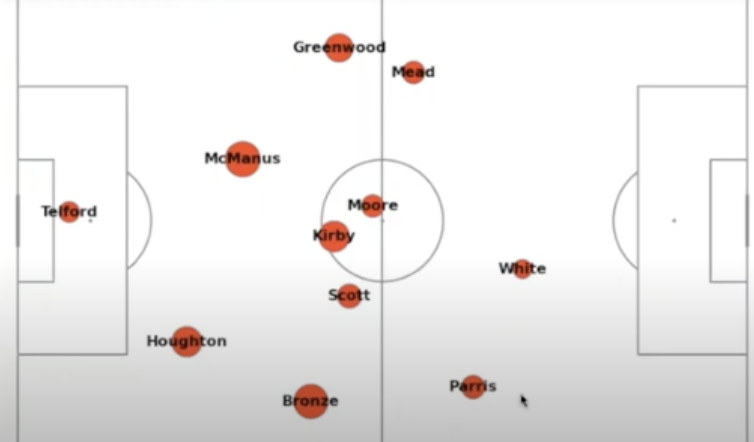
- Each point represents a player
- Thicker lines indicate a higher number of passes
- It’s immediately clear that Italy made a lot more successful passes than England
- Carroll managed to win the ball so many times from Hart’s kicks. Despite being on the pitch only half as long as most of the other players, he was one end of England’s most successful passing partnership
- But Hart and Carroll’s success reveals failures elsewhere. England had no consistent passing network in midfield. Instead, the Italians dominated the match, with 68% of possession and 36 shots. Italy passed the ball forward and England tried to kick it over their heads.
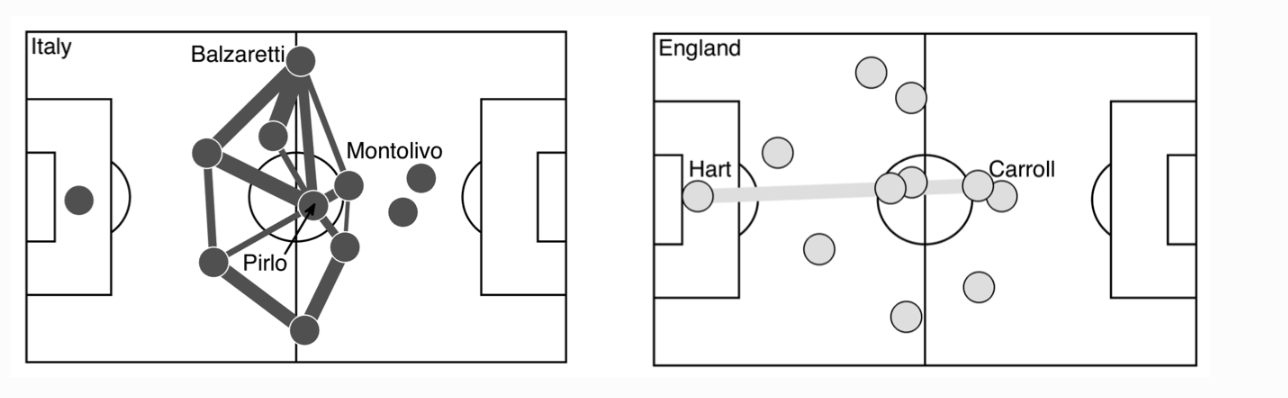

## Plotting edges
For each combination of players who made passes, we make a query to *scatter_df* to get the start and end of the line.
Then we adjust the line width so that the more passes between players, the wider the line.
As the next step, we plot the lines on the pitch. It is recommended that zorder of edges is lower than zorder of vertices.
In the end, we make the title.

In [9]:
#plot once again pitch and vertices
def plotting_edges(team_dict):
    # get the information regarding the passes between the home team     
    df_pass = team_dict['df_pass']
    lines_df = team_dict['lines_df']
    team_color = team_dict['color']
    team_name = team_dict['team_name']
    scatter_df = team_dict['scatter_df']
    
    pitch = Pitch(line_color='grey')
    fig, ax = pitch.grid(grid_height=0.9, title_height=0.06, axis=False,
                         endnote_height=0.04, title_space=0, endnote_space=0)
    pitch.scatter(scatter_df.x, scatter_df.y, s=scatter_df.marker_size, color=team_color, edgecolors='grey', linewidth=1, alpha=1, ax=ax["pitch"], zorder = 3)
    for i, row in scatter_df.iterrows():
        pitch.annotate(row['player.name'], xy=(row.x, row.y), c='black', va='center', ha='center', weight = "bold", size=16, ax=ax["pitch"], zorder = 4)

    for i, row in lines_df.iterrows():
            player1 = row["pair_key"].split("_")[0]
            player2 = row['pair_key'].split("_")[1]
            #take the average location of players to plot a line between them 
            player1_x = scatter_df.loc[scatter_df["player.name"] == player1]['x'].iloc[0]
            player1_y = scatter_df.loc[scatter_df["player.name"] == player1]['y'].iloc[0]
            player2_x = scatter_df.loc[scatter_df["player.name"] == player2]['x'].iloc[0]
            player2_y = scatter_df.loc[scatter_df["player.name"] == player2]['y'].iloc[0]
            num_passes = row["pass_count"]
            #adjust the line width so that the more passes, the wider the line
            line_width = (num_passes / lines_df['pass_count'].max() * 10)
            #plot lines on the pitch
            pitch.lines(player1_x, player1_y, player2_x, player2_y,
                            alpha=1, lw=line_width, zorder=2, color=team_color, ax = ax["pitch"])

    fig.suptitle(f"{team_name} Passing Network", fontsize = 30)
    plt.show()

In [10]:
def plotting_edges_two_teams(home_dict, away_dict):
    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(16, 6))

    # get the information regarding the passes between the home team     
    df_pass_h = home_dict['df_pass']
    lines_df_h = home_dict['lines_df']
    team_color_h = home_dict['color']
    team_name_h = home_dict['team_name']
    scatter_df_h = home_dict['scatter_df']
    
    # plot first subplot
    pitch1 = Pitch(line_color='grey')
    pitch1.scatter(scatter_df_h.x, scatter_df_h.y, s=scatter_df_h.marker_size, color=team_color_h, edgecolors='grey', linewidth=1, alpha=1, ax=axes[0], zorder = 3)
    for i, row in scatter_df_h.iterrows():
        pitch1.annotate(row['player.name'], xy=(row.x, row.y), c='black', va='center', ha='center', weight = "bold", size=16, ax=axes[0], zorder = 4)

    for i, row in lines_df_h.iterrows():
        player1 = row["pair_key"].split("_")[0]
        player2 = row['pair_key'].split("_")[1]
        player1_x = scatter_df_h.loc[scatter_df_h["player.name"] == player1]['x'].iloc[0]
        player1_y = scatter_df_h.loc[scatter_df_h["player.name"] == player1]['y'].iloc[0]
        player2_x = scatter_df_h.loc[scatter_df_h["player.name"] == player2]['x'].iloc[0]
        player2_y = scatter_df_h.loc[scatter_df_h["player.name"] == player2]['y'].iloc[0]
        num_passes = row["pass_count"]
        line_width = (num_passes / lines_df['pass_count'].max() * 10)
        pitch1.lines(player1_x, player1_y, player2_x, player2_y,alpha=1, lw=line_width, zorder=2, color=team_color_h, ax = axes[0])
    # pitch1.title(f"{team_name_h} Passing Network")
    
    
    # get the information regarding the passes between the home team     
    df_pass_a = away_dict['df_pass']
    lines_df_a = away_dict['lines_df']
    team_color_a = away_dict['color']
    team_name_a = away_dict['team_name']
    scatter_df_a = away_dict['scatter_df']
    
    # plot first subplot
    pitch2 = Pitch(line_color='grey')
    pitch2.scatter(scatter_df_a.x, scatter_df_a.y, s=scatter_df_a.marker_size, color=team_color_a, edgecolors='grey', linewidth=1, alpha=1, ax=axes[1], zorder = 3)
    for i, row in scatter_df_a.iterrows():
        pitch2.annotate(row['player.name'], xy=(row.x, row.y), c='black', va='center', ha='center', weight = "bold", size=16, ax=axes[1], zorder = 4)

    for i, row in lines_df_a.iterrows():
        player1 = row["pair_key"].split("_")[0]
        player2 = row['pair_key'].split("_")[1]
        player1_x = scatter_df_a.loc[scatter_df_a["player.name"] == player1]['x'].iloc[0]
        player1_y = scatter_df_a.loc[scatter_df_a["player.name"] == player1]['y'].iloc[0]
        player2_x = scatter_df_a.loc[scatter_df_a["player.name"] == player2]['x'].iloc[0]
        player2_y = scatter_df_a.loc[scatter_df_a["player.name"] == player2]['y'].iloc[0]
        num_passes = row["pass_count"]
        line_width = (num_passes / lines_df['pass_count'].max() * 10)
        pitch2.lines(player1_x, player1_y, player2_x, player2_y,alpha=1, lw=line_width, zorder=2, color=team_color_a, ax = axes[1])

    pitch1.title(f"{team_name_h} Passing Network")
    pitch2.title(f"{team_name_a} Passing Network")

    plt.show()


In [11]:
# home team passing network
df_pass_home = prepare_data_pass(df,team_name=teams_comp[0])

df_pass_edges_home,lines_df_home,scatter_df_home = calculate_edges_width(df_pass_home)

home_dict = \
{
    'df_pass' : df_pass_home,
    'lines_df' : lines_df_home,
    'scatter_df' : scatter_df_home,
    'color': 'red',
    'team_name' : teams_comp[0]
}

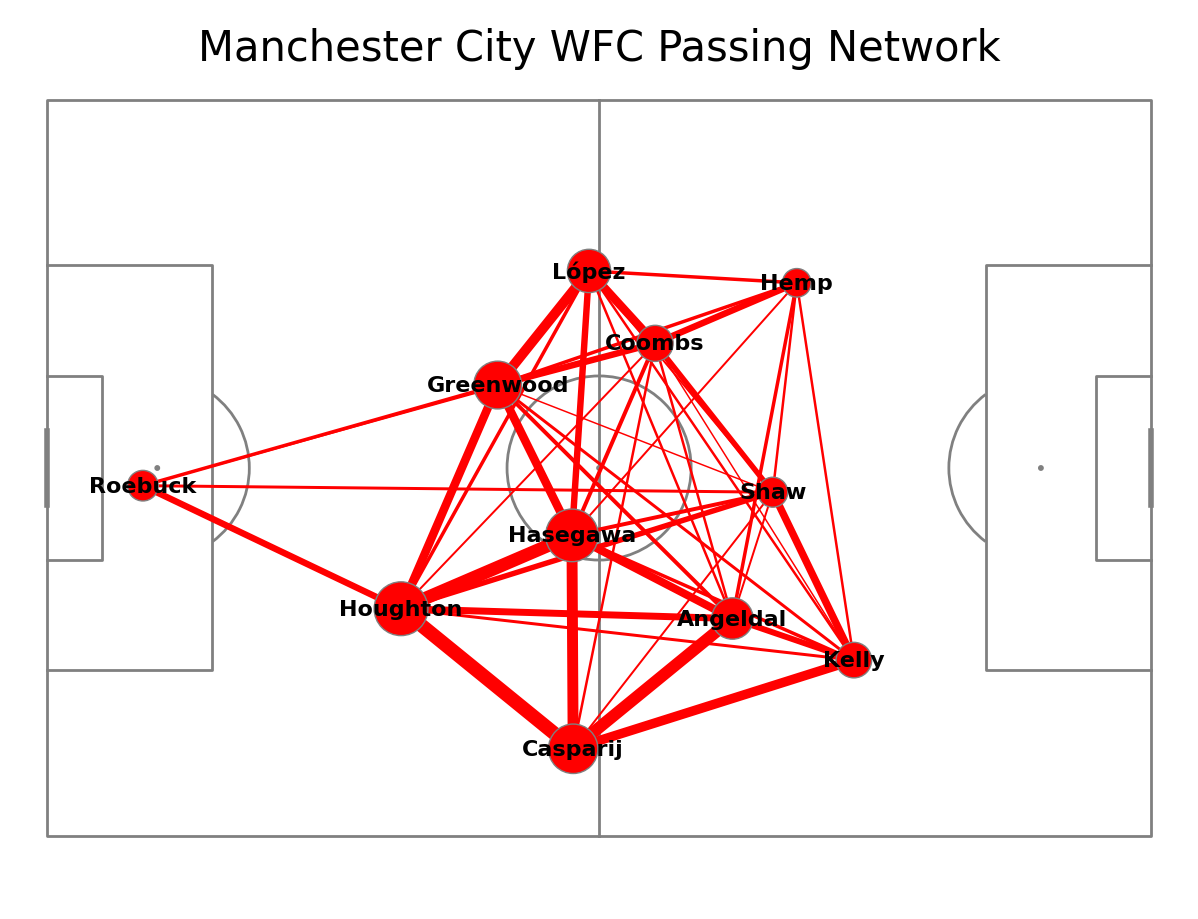

In [12]:
plotting_edges(home_dict)

In [29]:
# home team passing network
df_pass_away = prepare_data_pass(df,team_name=teams_comp[1])

df_pass_edges_away,lines_df_away,scatter_df_away = calculate_edges_width(df_pass_away)

away_dict = \
{
    'df_pass' : df_pass_away,
    'lines_df' : lines_df_away,
    'scatter_df' : scatter_df_away,
    'color': 'blue',
    'team_name' : teams_comp[1]
}

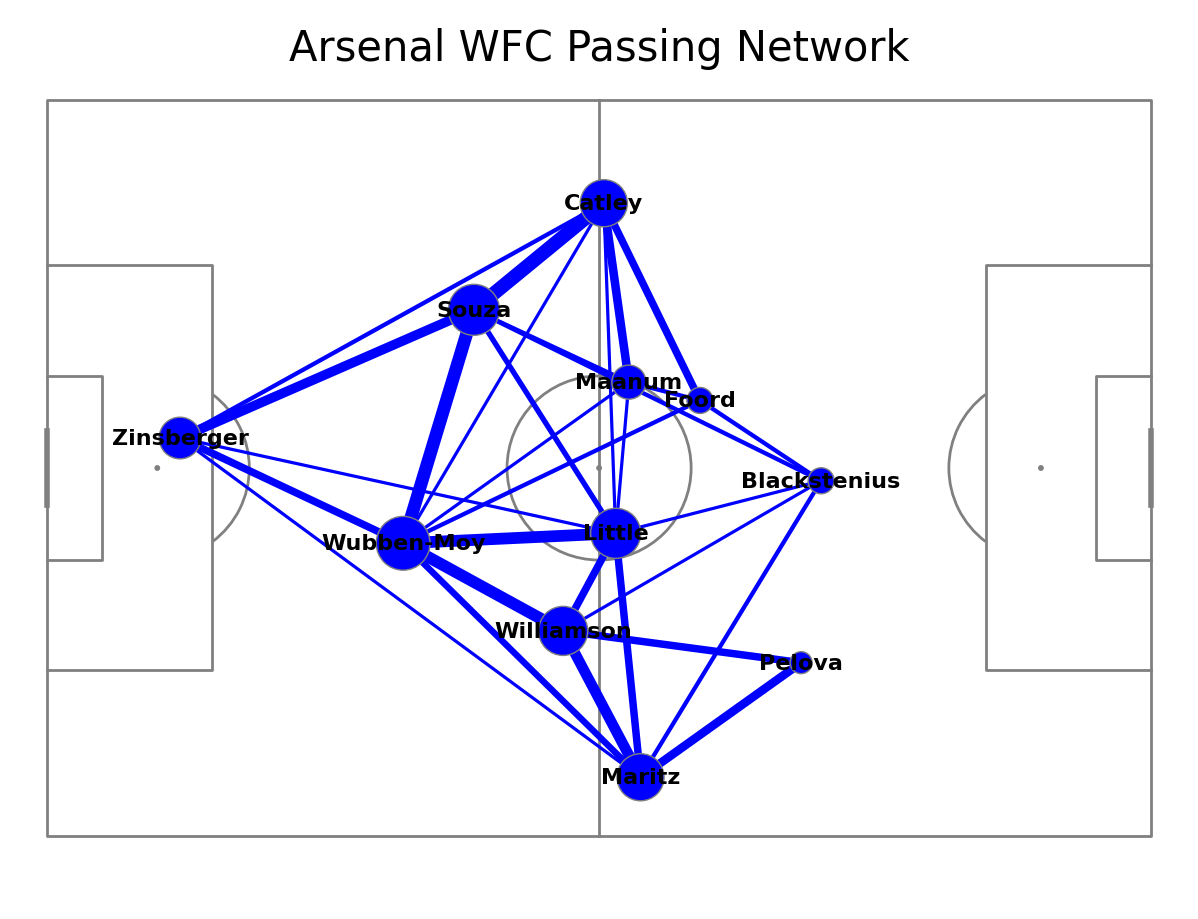

In [30]:
plotting_edges(away_dict)

## Centralisation
To calculate the centralisation index we need to calculate number of passes made by each player. 
Then, we calculate the denominator - the sum of all passes multiplied by (number of players - 1) -> 10
To calculate the numerator we sum the difference between maximal number of successful passes by 1 player
and number of successful passes by each player. We calculate the index dividing the numerator by denominator.

In [ ]:
#calculate number of successful passes by player
no_passes = df_pass.groupby(['player.name']).x.count().reset_index()
no_passes.rename({'x':'pass_count'}, axis='columns', inplace=True)
#find one who made most passes
max_no = no_passes["pass_count"].max() 
#calculate the denominator - 10*the total sum of passes
denominator = 10*no_passes["pass_count"].sum() 
#calculate the nominator
nominator = (max_no - no_passes["pass_count"]).sum()
#calculate the centralisation index
centralisation_index = nominator/denominator
print("Centralisation index is ", centralisation_index)

## Passing Network for Forward Passes

In [32]:
df_forward_passes_home = df_pass_home[df_pass_home['x']<df_pass_home['end_x']]

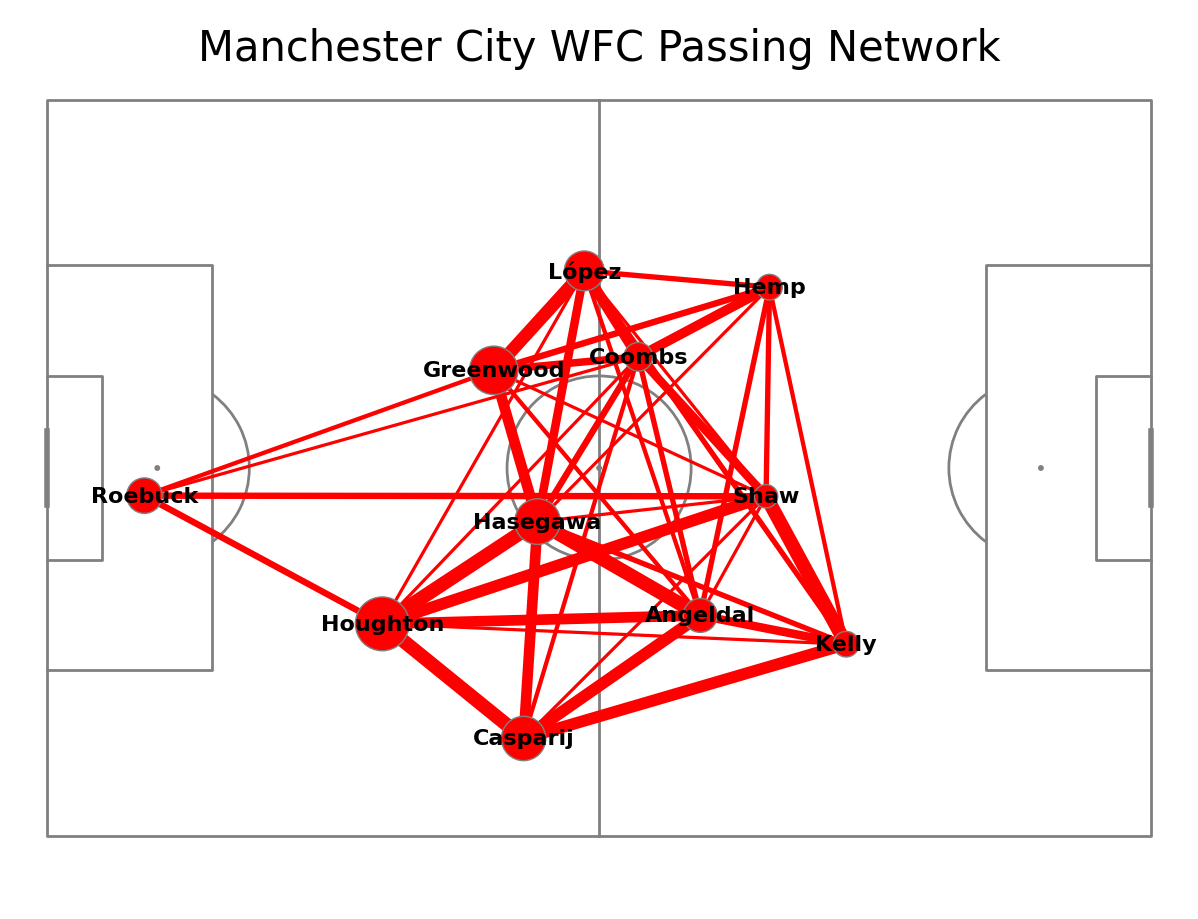

In [33]:
df_pass_edges_forward_home,lines_df_forward_home,scatter_df_forward_home = calculate_edges_width(df_forward_passes_home)

home_dict_forward = \
{
    'df_pass' : df_pass_edges_forward_home,
    'lines_df' : lines_df_forward_home,
    'scatter_df' : scatter_df_forward_home,
    'color': 'red',
    'team_name' : teams_comp[0]
}

plotting_edges(home_dict_forward)

In [35]:
df_forward_passes_away = df_pass_away[df_pass_away['x']<df_pass_away['end_x']]

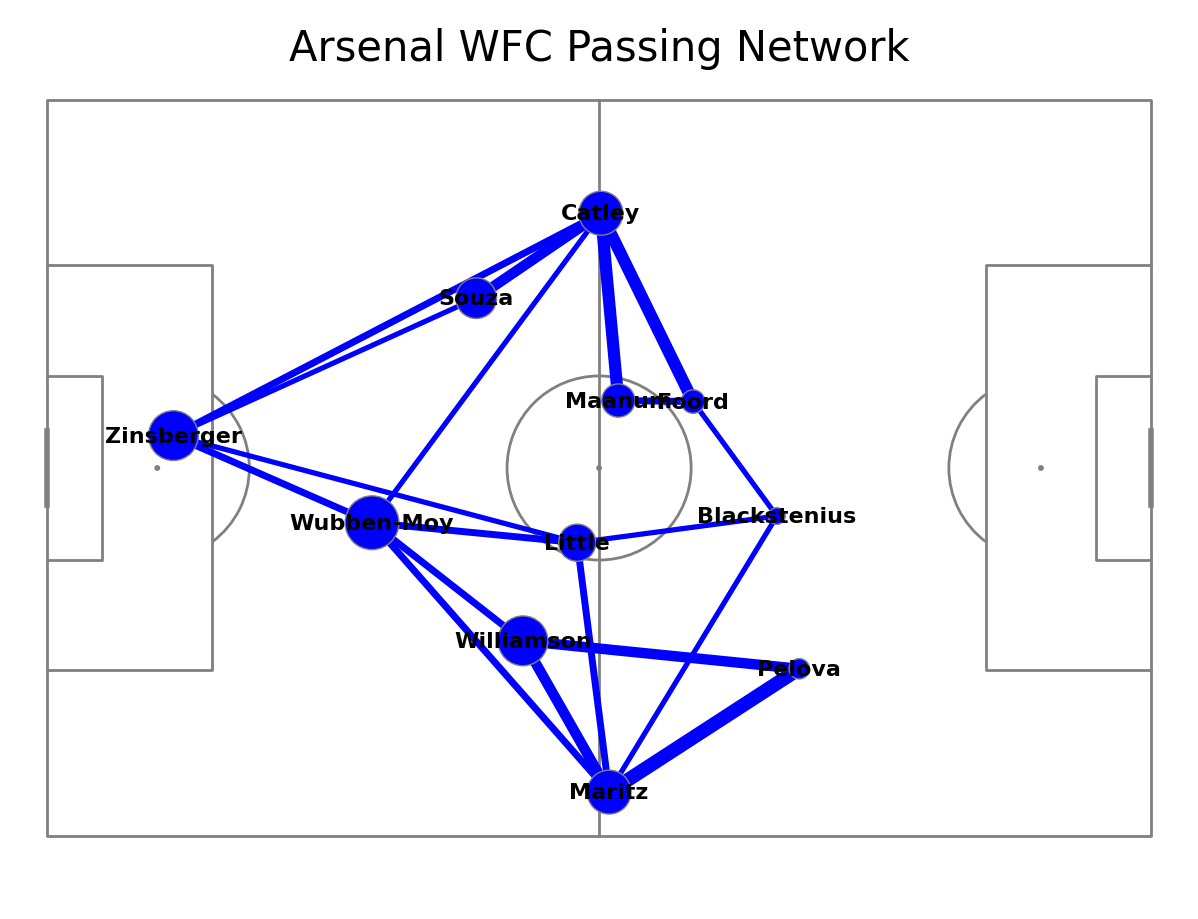

In [36]:
df_pass_edges_forward_away,lines_df_forward_away,scatter_df_forward_away = calculate_edges_width(df_forward_passes_away)

away_dict_forward = \
{
    'df_pass' : df_pass_edges_forward_away,
    'lines_df' : lines_df_forward_away,
    'scatter_df' : scatter_df_forward_away,
    'color': 'blue',
    'team_name' : teams_comp[1]
}

plotting_edges(away_dict_forward)

## Plotting multiple pass maps on one figure

In [ ]:
 #check for index of first sub
    if sub:
        sub = df.loc[df["type.name"] == "Substitution"].loc[df["team.name"] == team_name].iloc[0]["index"]

    #make df with successfull passes by Manchester City until the first substitution
    if sub:
        mask_mancity = (df['type.name'] == 'Pass')\
        & (df['team.name']==team_name) \
        & (df.index < sub) \
        &(df['substitution.replacement.name'].isnull())\
        &(~df['pass.recipient.name'].isnull())
    else:
        mask_mancity = (df['type.name'] == 'Pass')\
        & (df['team.name']==team_name) \
        &(df['substitution.replacement.name'].isnull())\
        &(~df['pass.recipient.name'].isnull()) 

    #taking necessary columns
    df_pass_details = df.loc[mask_mancity, ['location','pass.end_location','player.name','pass.recipient.name']]


In [47]:
#prepare the dataframe of passes by the team that were no-throw ins
def prepare_passes_each_player(df,team_name):
    mask_team = (df['type.name'] == 'Pass') & (df['team.name'] == team_name)
    #taking necessary columns
    df_pass_details = df.loc[mask_team, ['location','pass.end_location','player.name','pass.recipient.name']]
    #get the list of all players who made a pass
    names = df_pass_details['player.name'].unique()

    df_pass_details['x'] = [axes[0] for axes in df_pass_details['location'].values]
    df_pass_details['y'] = [axes[1] for axes in df_pass_details['location'].values]

    df_pass_details['end_x'] = [axes[0] for axes in df_pass_details['pass.end_location'].values]
    df_pass_details['end_y'] = [axes[1] for axes in df_pass_details['pass.end_location'].values]

    df_passes = df_pass_details[['x', 'y', 'end_x', 'end_y','player.name','pass.recipient.name']]
    return df_passes 

#draw 4x4 pitches
def plot_pitch_passes(df_passes,home_team,away_team):
    pitch = Pitch(line_color='black', pad_top=20)
    fig, axs = pitch.grid(ncols = 4, nrows = 4, grid_height=0.85, title_height=0.06, axis=False,
                         endnote_height=0.04, title_space=0.04, endnote_space=0.01)

    #for each player
    for name, ax in zip(names, axs['pitch'].flat[:len(names)]):
        #put player name over the plot
        ax.text(60, -10, name,
                ha='center', va='center', fontsize=14)
        #take only passes by this player
        player_df = df_passes.loc[df_passes["player.name"] == name]
        #scatter
        pitch.scatter(player_df.x, player_df.y, alpha = 0.2, s = 50, color = "blue", ax=ax)
        #plot arrow
        pitch.arrows(player_df.x, player_df.y,
                player_df.end_x, player_df.end_y, color = "blue", ax=ax, width=1)

    #We have more than enough pitches - remove them
    for ax in axs['pitch'][-1, 16 - len(names):]:
        ax.remove()

    #Another way to set title using mplsoccer
    axs['title'].text(0.5, 0.5, f'{teams_comp[0]} passes against {teams_comp[1]}', ha='center', va='center', fontsize=30)
    plt.show()

In [48]:
df_passes_each_player = prepare_passes_each_player(df,teams_comp[0])

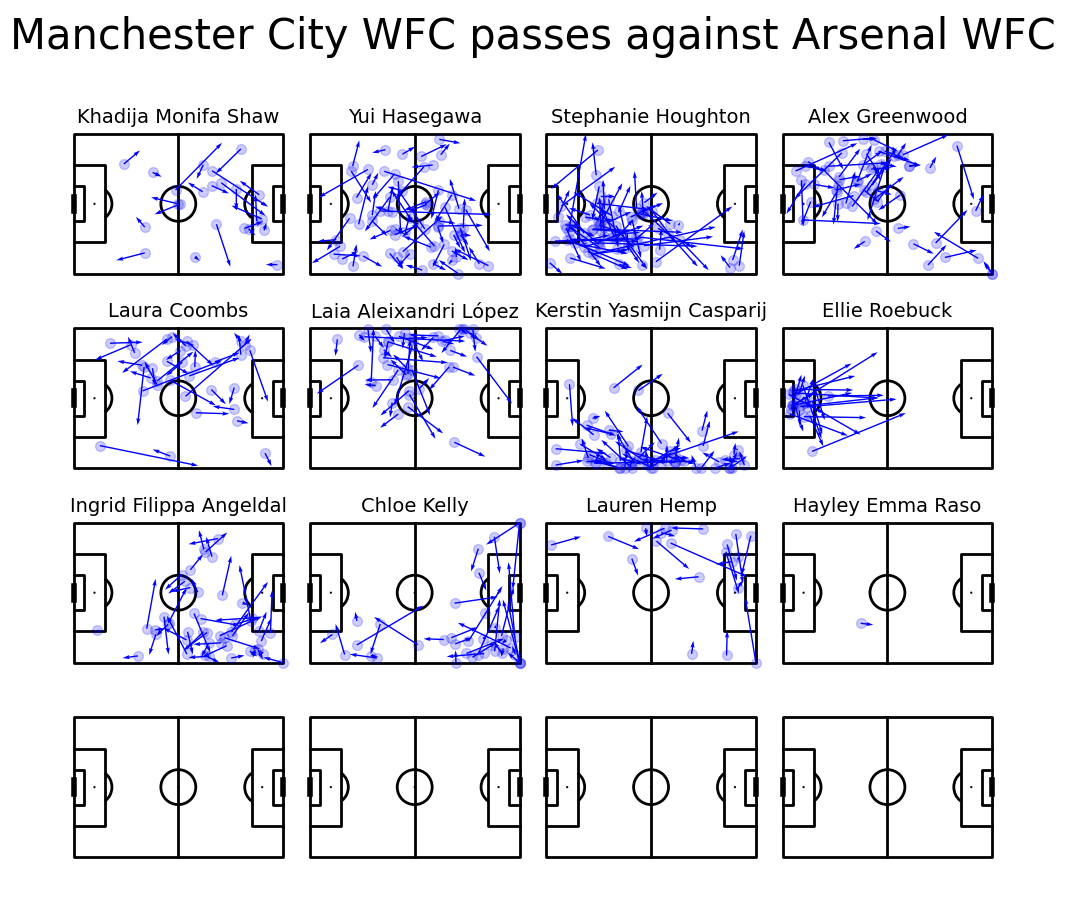

In [49]:
plot_pitch_passes(df_passes_each_player,home_team=teams_comp[0],away_team=teams_comp[1])

## Finding danger passes
- Look for the passes 15 seconds before a shot.

In [50]:
#declare an empty dataframe
def danger_passes_all_matches():
    danger_passes = pd.DataFrame()
    for idx in match_ids:
        #open the event data from this game
        df = parser.event(idx)[0]
        for period in [1, 2]:
            #keep only accurate passes by England that were not set pieces in this period
            mask_pass = (df.team_name == team) & (df.type_name == "Pass") & (df.outcome_name.isnull()) & (df.period == period) & (df.sub_type_name.isnull())
            #keep only necessary columns
            passes = df.loc[mask_pass, ["x", "y", "end_x", "end_y", "minute", "second", "player_name"]]
            #keep only Shots by England in this period
            mask_shot = (df.team_name == team) & (df.type_name == "Shot") & (df.period == period)
            #keep only necessary columns
            shots = df.loc[mask_shot, ["minute", "second"]]
            #convert time to seconds
            shot_times = shots['minute']*60+shots['second']
            shot_window = 15
            #find starts of the window
            shot_start = shot_times - shot_window
            #condition to avoid negative shot starts
            shot_start = shot_start.apply(lambda i: i if i>0 else (period-1)*45)
            #convert to seconds
            pass_times = passes['minute']*60+passes['second']
            #check if pass is in any of the windows for this half
            pass_to_shot = pass_times.apply(lambda x: True in ((shot_start < x) & (x < shot_times)).unique())

            #keep only danger passes
            danger_passes_period = passes.loc[pass_to_shot]
            #concatenate dataframe with a previous one to keep danger passes from the whole tournament
            danger_passes = pd.concat([danger_passes, danger_passes_period], ignore_index = True)

In [78]:
#taking necessary columns
def get_mask_df(df,mask_pass):
    df_pass_details = df.loc[mask_pass, ['location','pass.end_location','player.name','pass.recipient.name','minute', 'second']]

    df_pass_details['x'] = [axes[0] for axes in df_pass_details['location'].values]
    df_pass_details['y'] = [axes[1] for axes in df_pass_details['location'].values]

    df_pass_details['end_x'] = [axes[0] for axes in df_pass_details['pass.end_location'].values]
    df_pass_details['end_y'] = [axes[1] for axes in df_pass_details['pass.end_location'].values]

    df_pass = df_pass_details[['x', 'y', 'end_x', 'end_y','player.name','pass.recipient.name','minute', 'second']]
    return df_pass

In [92]:
period = 1
#keep only accurate passes by England that were not set pieces in this period
danger_passes = pd.DataFrame()
mask_pass = \
(df['team.name'] == teams_comp[0]) \
& (df['type.name'] == "Pass") \
& (~df['pass.recipient.name'].isnull()) \
& (df['period'] == period) \
# & (df.sub_type_name.isnull())

#keep only necessary columns
passes = get_mask_df(df,mask_pass)

#keep only Shots by England in this period
mask_shot = (df['team.name'] == teams_comp[0]) & (df['type.name'] == "Shot") & (df.period == period)

#keep only necessary columns
shots = df.loc[mask_shot, ["minute", "second"]]

#convert time to seconds
shot_times = shots['minute']*60+shots['second']
shot_window = 15
#find starts of the window
shot_start = shot_times - shot_window

#condition to avoid negative shot starts
shot_start = shot_start.apply(lambda i: i if i>0 else (period-1)*45)
#convert to seconds
pass_times = passes['minute']*60+passes['second']
#check if pass is in any of the windows for this half
pass_to_shot = pass_times.apply(lambda x: True in ((shot_start < x) & (x < shot_times)).unique())

#keep only danger passes
danger_passes_period = passes.loc[pass_to_shot]

In [93]:
danger_passes = pd.concat([danger_passes,danger_passes_period])

## Plotting location of danger passes

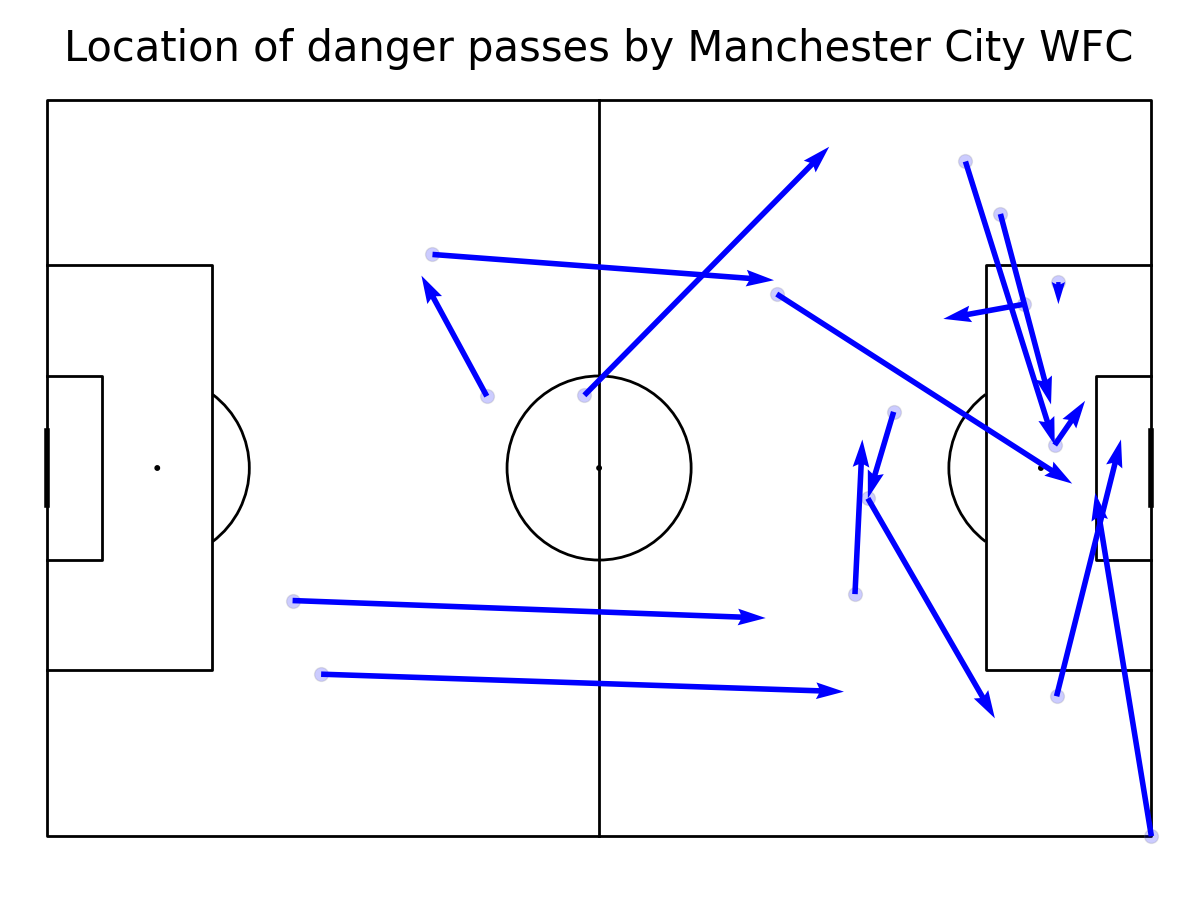

In [97]:
#plot pitch
pitch = Pitch(line_color='black')
fig, ax = pitch.grid(grid_height=0.9, title_height=0.06, axis=False,
                     endnote_height=0.04, title_space=0, endnote_space=0)
#scatter the location on the pitch
pitch.scatter(danger_passes.x, danger_passes.y, s=100, color='blue', edgecolors='grey', linewidth=1, alpha=0.2, ax=ax["pitch"])
#uncomment it to plot arrows
pitch.arrows(danger_passes.x, danger_passes.y, danger_passes.end_x, danger_passes.end_y, color = "blue", ax=ax['pitch'])
#add title
fig.suptitle('Location of danger passes by ' + teams_comp[0], fontsize = 30)
plt.show()

## Making a heat map
- Calculate the number of passes in each bin using bin_statistic method
- Normalize number of passes by number of games
- Plot a heat map

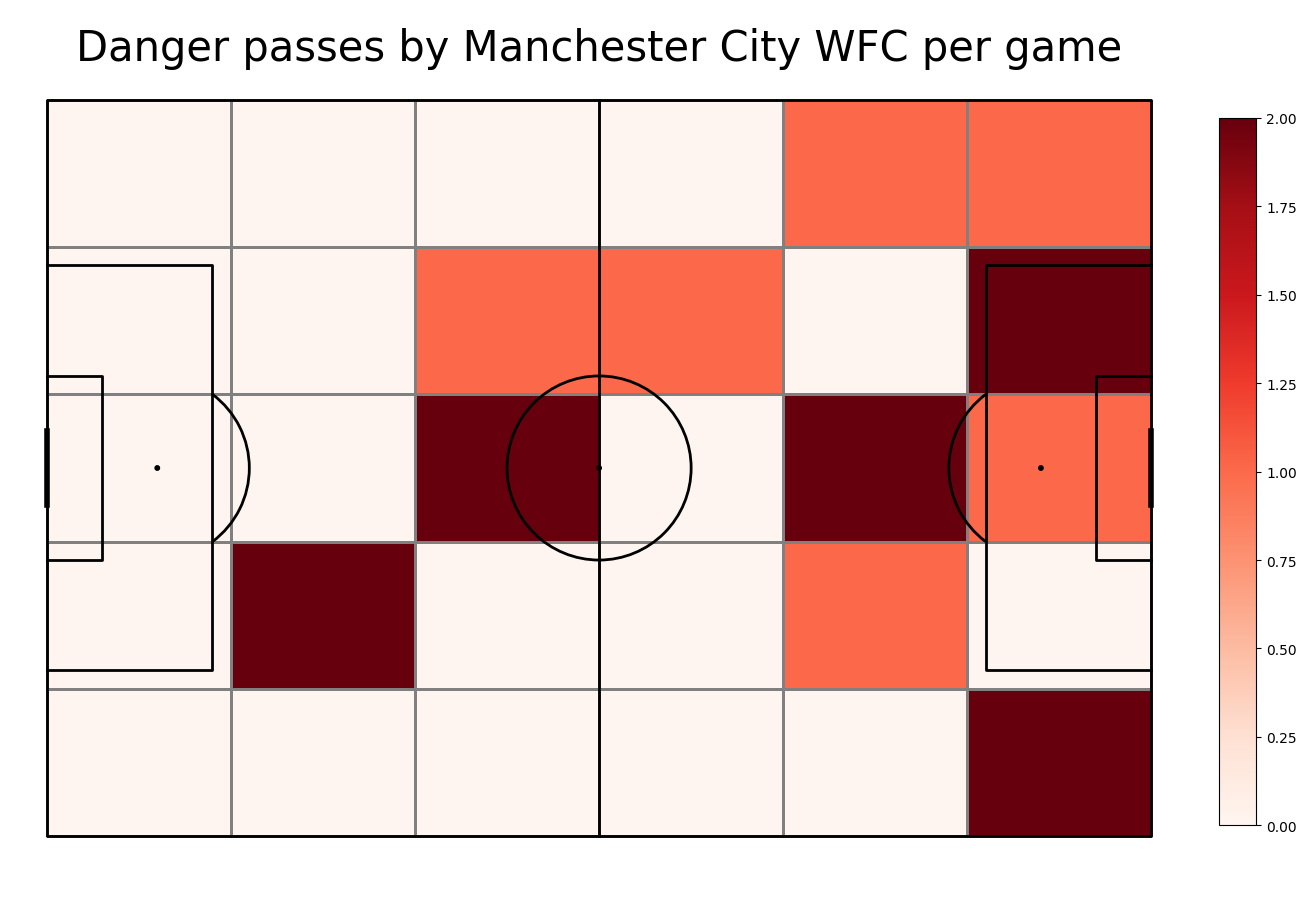

In [100]:
no_games = 1
team = teams_comp[0]
#plot vertical pitch
pitch = Pitch(line_zorder=2, line_color='black')
fig, ax = pitch.grid(grid_height=0.9, title_height=0.06, axis=False,
                     endnote_height=0.04, title_space=0, endnote_space=0)
#get the 2D histogram
bin_statistic = pitch.bin_statistic(danger_passes.x, danger_passes.y, statistic='count', bins=(6, 5), normalize=False)
#normalize by number of games
bin_statistic["statistic"] = bin_statistic["statistic"]/no_games
#make a heatmap
pcm  = pitch.heatmap(bin_statistic, cmap='Reds', edgecolor='grey', ax=ax['pitch'])
#legend to our plot
ax_cbar = fig.add_axes((1, 0.093, 0.03, 0.786))
cbar = plt.colorbar(pcm, cax=ax_cbar)
fig.suptitle('Danger passes by ' + team + " per game", fontsize = 30)
plt.show()

## Making a diagram of most involved players

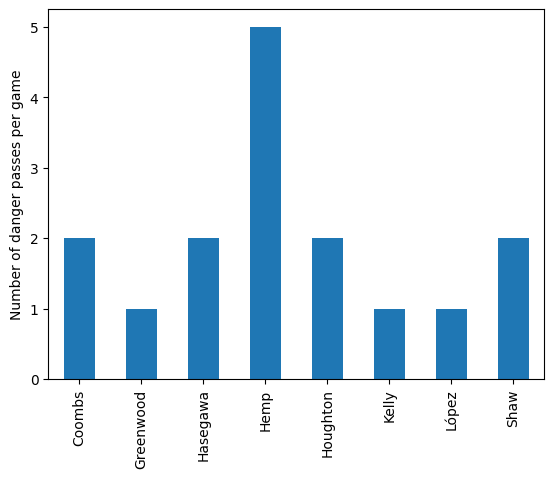

In [102]:
#keep only surnames
danger_passes["player.name"] = danger_passes["player.name"].apply(lambda x: str(x).split()[-1])
#count passes by player and normalize them
pass_count = danger_passes.groupby(["player.name"]).x.count()/no_games
#make a histogram
ax = pass_count.plot.bar(pass_count)
#make legend
ax.set_xlabel("")
ax.set_ylabel("Number of danger passes per game")
plt.show()

## Case study: attacking play
### Summarising attacking play
- By looking at the passes we can find out where players are creating problems for the opposition
- The darker the area the more passes he has made per 90 minutes. The blue arrows show the average direction of his passes.

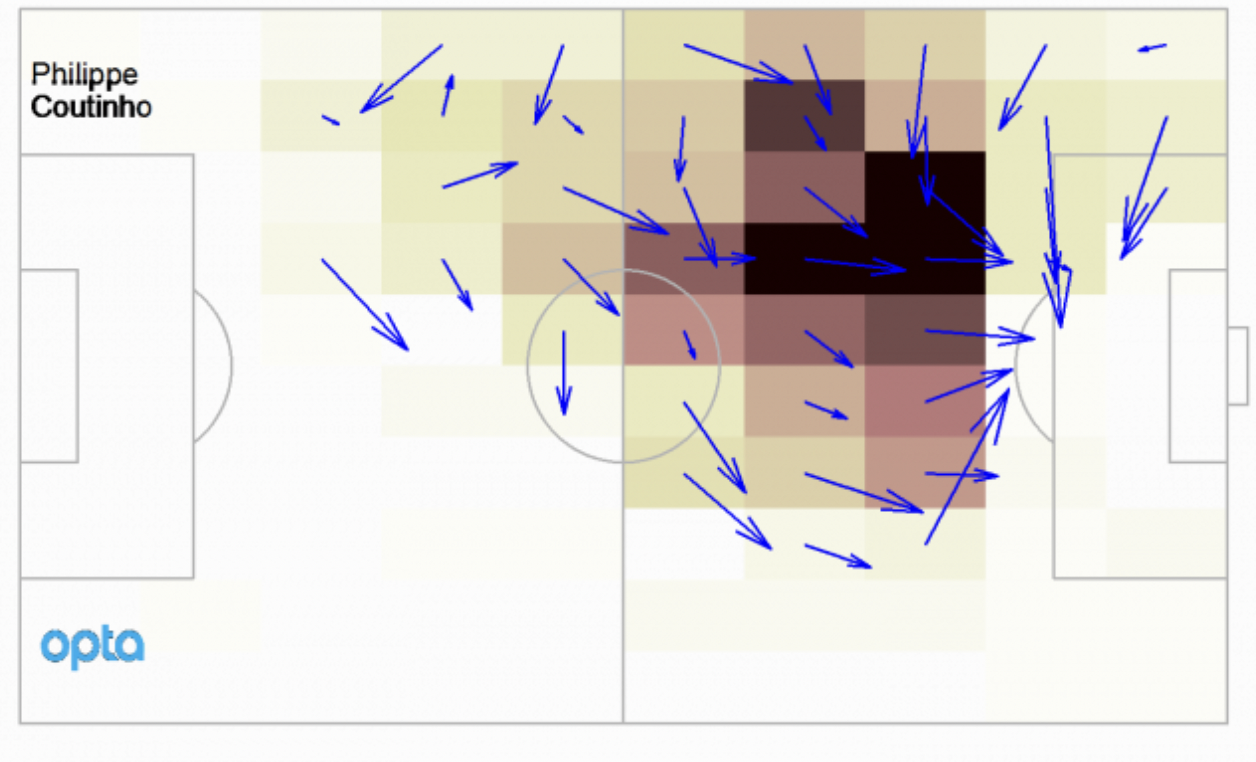

### Thinks to think about
- Heat maps are spatial histograms. Each square on the heat map shows the number of passes made by the player from that square.
- The ‘hotter’ the square, the more passes made.
- For example, we can look at where passes are received. This is a good way of assessing strikers, who make fewer passes but are often on the end of them. 
- Defensive heat maps can also be made by looking at where players recover the ball.

## Case study: 5-second rule (KPI)

### Getting the ball back
- Attributed to Pep Guardiola Barcelona’s team of 2008-12
- “if you lose the ball when attacking then regain it within five seconds, if not fall back in to a more traditional defence”
- It is important to also take in to account of position on the field.
- The ‘five-second-rule’ is mainly used in **attack**, so **regains in the final third are more important (and often more dangerous) than in the team’s own half**
- **KPI: how often do we get the ball back within 5 seconds after we lose it.**

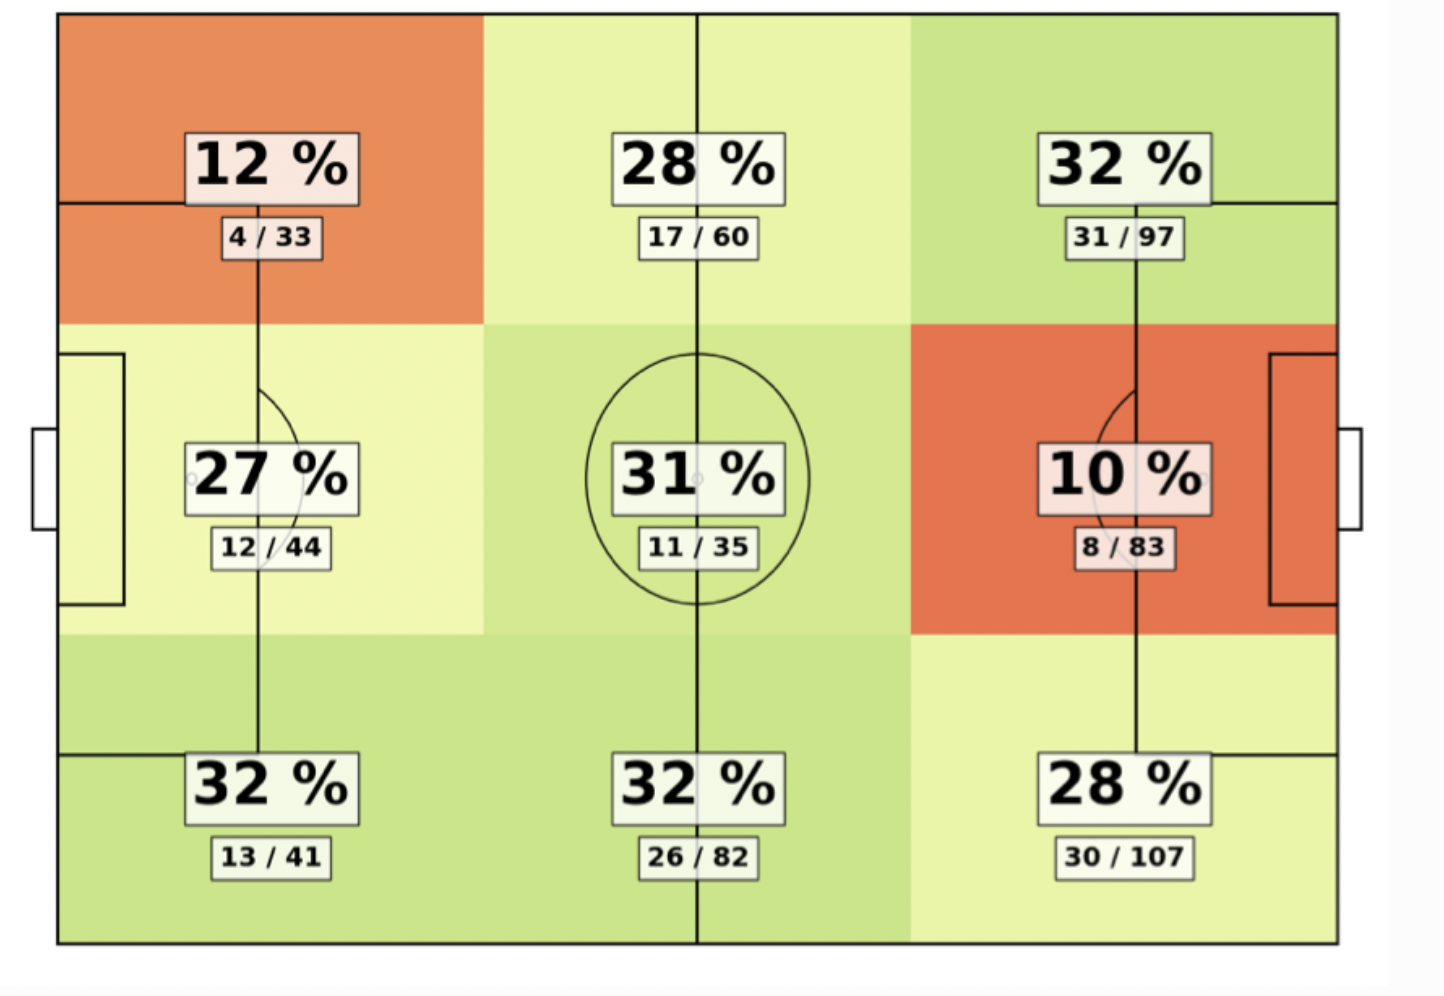

- The percent is the proportion of times that Hammarby recovered the ball after they lost it in each section of the pitch. 
- The key to creating a good KPI is finding something that combines the practices of grassroots football and the culture of measurement and prediction.
- When creating a KPI you should ask yourself the following question: **why are you collecting a KPI about a football team?**
- A measurement should be something which helps everyone move toward, an attempt to capture something that the whole organisation agrees it is worth measuring

### Methodology
1. Identify all the balls that our team lost during the match (df['interception.name'])
2. Identify which lost ball were regained within 5 secs

In [111]:
df['type.name'].value_counts()

Pass                 962
Ball Receipt*        925
Carry                806
Pressure             360
Ball Recovery        111
Duel                  65
Dribble               46
Interception          44
Block                 41
Clearance             41
Goal Keeper           31
Dribbled Past         28
Miscontrol            27
Dispossessed          23
Foul Committed        22
Foul Won              22
Shot                  22
Injury Stoppage        9
50/50                  8
Substitution           6
Referee Ball-Drop      6
Half Start             4
Half End               4
Player On              4
Player Off             4
Starting XI            2
Error                  2
Offside                1
Tactical Shift         1
Bad Behaviour          1
Shield                 1
Name: type.name, dtype: int64

In [164]:
df[(df['type.name']=='Pressure')].head()

,id,index,period,timestamp,minute,second,possession,obv_for_after,obv_for_before,obv_for_net,...,substitution.replacement.name,pass.inswinging,foul_committed.card.id,foul_committed.card.name,bad_behaviour.card.id,bad_behaviour.card.name,pass.miscommunication,pass.cut_back,dribble.overrun,pass.outswinging
14,c5cfd071-adc7-455f-a7a9-ed7b7a9da9e4,15,1,00:00:07.979,0,7,2,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
26,c57a1294-5d54-426e-a35b-2ff7188c95ed,27,1,00:00:14.721,0,14,2,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
42,68917175-3dc1-4644-92b6-a7b749c2bdda,43,1,00:00:35.822,0,35,3,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
52,f82ee0e3-0a20-480c-8c0c-c7e5162f8644,53,1,00:00:43.667,0,43,3,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
56,71fe66e7-bab1-4a0a-8907-e59015b1bfc4,57,1,00:00:45.026,0,45,3,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [160]:
df[(df['team.name']==teams_comp[0]) & (df['type.name']=='Ball Recovery')].shape

(54, 127)

In [165]:
df[(df['team.name']==teams_comp[1]) & (df['type.name']=='Block') ].head()

,id,index,period,timestamp,minute,second,possession,obv_for_after,obv_for_before,obv_for_net,...,substitution.replacement.name,pass.inswinging,foul_committed.card.id,foul_committed.card.name,bad_behaviour.card.id,bad_behaviour.card.name,pass.miscommunication,pass.cut_back,dribble.overrun,pass.outswinging
117,6bb35d54-6c55-47a8-9723-faa2b0b2196f,118,1,00:02:09.679,2,9,6,0.007819,0.008448,-0.000629,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
279,1733df8c-f7da-4d15-b2db-19484fecb54f,280,1,00:05:42.516,5,42,11,0.008291,0.008470,-0.000179,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
395,13235f82-8b05-40d8-81a2-9653dbbdafa3,396,1,00:08:05.545,8,5,17,0.009275,0.009563,-0.000288,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
534,8602c4e6-dfda-4c5a-95ae-c55c3ccd17d7,535,1,00:11:04.299,11,4,29,0.008691,0.009513,-0.000822,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
652,6a129229-30d6-492e-aae2-f2f69197a306,653,1,00:13:32.976,13,32,33,0.034115,0.015136,0.018979,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [161]:
df[(df['team.name']==teams_comp[1]) & (df['type.name']=='Ball Recovery') ].shape

(57, 127)

In [166]:
df[(df['minute']==5) & (df['team.name']==teams_comp[1]) & (df['possession_team.name']==teams_comp[1])].head()

,id,index,period,timestamp,minute,second,possession,obv_for_after,obv_for_before,obv_for_net,...,substitution.replacement.name,pass.inswinging,foul_committed.card.id,foul_committed.card.name,bad_behaviour.card.id,bad_behaviour.card.name,pass.miscommunication,pass.cut_back,dribble.overrun,pass.outswinging
280,cc228a6a-5f11-4269-ae9e-5cd91ab57328,281,1,00:05:43.926,5,43,12,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
281,ca4d1765-5c6c-479a-ac02-2fd1a3150543,282,1,00:05:43.926,5,43,12,0.012122,0.008291,0.003832,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
283,3701b1a2-8180-4fc2-9f05-e8a2c0c1652c,284,1,00:05:46.659,5,46,12,0.009920,0.012122,-0.002202,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
285,e7740d2a-6498-4d85-813a-e8ecc2a560fa,286,1,00:05:48.069,5,48,12,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
286,ce19b77f-e732-42eb-9739-252204cae6f8,287,1,00:05:48.069,5,48,12,0.011102,0.009920,0.001182,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [167]:
df[(df['minute']==5) & (df['type.name']=='Pass') & (df['team.name']==teams_comp[0])].head()

,id,index,period,timestamp,minute,second,possession,obv_for_after,obv_for_before,obv_for_net,...,substitution.replacement.name,pass.inswinging,foul_committed.card.id,foul_committed.card.name,bad_behaviour.card.id,bad_behaviour.card.name,pass.miscommunication,pass.cut_back,dribble.overrun,pass.outswinging
231,983ee20e-5680-4a31-9bac-e869107baed7,232,1,00:05:00.154,5,0,11,0.015038,0.013382,0.001656,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
233,baf70198-6fe1-43fa-a887-e2f09bdfd6a6,234,1,00:05:00.983,5,0,11,0.013377,0.015038,-0.001661,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
238,7bbd2389-faf0-464d-a4c6-90d665022c4f,239,1,00:05:02.649,5,2,11,0.021465,0.014966,0.006499,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
242,98671242-fca3-4f64-bc4d-62aaf87541e0,243,1,00:05:05.997,5,5,11,0.011011,0.025405,-0.014394,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
250,898ce0d0-5633-460a-b197-307415001b71,251,1,00:05:12.944,5,12,11,0.024342,0.054995,-0.030653,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [168]:
df[(df['play_pattern.name']=='Regular Play')\
   & (df['team.name']==teams_comp[0])].head()

,id,index,period,timestamp,minute,second,possession,obv_for_after,obv_for_before,obv_for_net,...,substitution.replacement.name,pass.inswinging,foul_committed.card.id,foul_committed.card.name,bad_behaviour.card.id,bad_behaviour.card.name,pass.miscommunication,pass.cut_back,dribble.overrun,pass.outswinging
0,5ab3a8e3-e6e1-4a94-b057-57b2301abac5,1,1,00:00:00.000,0,0,1,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,7b3793be-f0aa-40b5-aedf-e2ec45e43069,3,1,00:00:00.000,0,0,1,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
40,b9cf5a76-1ae3-4715-9825-ac0822cac2dd,41,1,00:00:34.454,0,34,3,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
43,270fe2a8-3d10-47ef-9d30-3db2a8a3c1fc,44,1,00:00:36.169,0,36,3,0.009959,0.009398,0.000561,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
44,185da75f-0ef5-42b9-82a4-304dadaa0db3,45,1,00:00:38.614,0,38,3,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [114]:
df['interception.outcome.name'].value_counts()

Won                24
Success In Play    10
Lost In Play        6
Lost Out            4
Name: interception.outcome.name, dtype: int64

In [121]:
(df['interception.outcome.name'].isin(['Lost In Play','Lost Out']) \
& df['team.name'] == teams_comp[0])

0       False
1       False
2       False
3       False
4       False
        ...  
3624    False
3625    False
3626    False
3627    False
3628    False
Length: 3629, dtype: bool